In [1]:
import pandas as pd
import numpy as np
from pandas import read_csv
from matplotlib import pyplot
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import read_csv
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot

from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.arima_model import ARIMA

# Data Preparation


In [161]:
#Read data
# One file per semester
def get_data():
    df0 = pd.read_csv("2015_S2.csv", sep = ";")
    df1 = pd.read_csv("2016_S1.csv", sep = ";")
    df2 = pd.read_csv("2016_S2.csv", sep = ";")
    df3 = pd.read_csv("2017_S1.csv", sep = ";")
    df4 = pd.read_csv("2017_S2.csv", sep = ";")
    df5 = pd.read_csv("2018_S1.csv", sep = ";")
    df6 = pd.read_csv("2018_S2.csv", sep = ";")
    df7 = pd.read_csv("2019_S1.csv", sep = ";")
    df8 = pd.read_csv("2019_S2.csv", sep = ";")

    data0 = pd.concat([df0, df1, df2, df3, df4, df5, df6, df7, df8], ignore_index=True)
    return data0

In [139]:
# Function converting scenario to one_hot
def scenario_one_hot(data, one_hot = False):
    #extract numeric data from scenario 'S1' to '1' 
    data['scenario_num'] = (data['scenario'].str.extract('(\d+)')).astype(int)
    data.drop(['scenario'], axis=1, inplace=True)
    
    #add one-hot encoding to scenario: 
    if one_hot:
        scenario = pd.get_dummies(data['scenario_num'], prefix = 'scenario', dummy_na=True)
        data1= pd.concat([data, scenario], axis=1)
        return data1
    return data

#test: 
# data= scenario_one_hot(data)

In [140]:
# Functions to make cyclical data into continuous data using cos & sin
def smooth_wind_dir(data):
    data['cos_wind_dir'] = np.cos(2*np.pi*data['wind_dir']/360)
    data['sin_wind_dir'] = np.sin(2*np.pi*data['wind_dir']/360)
    data.drop(['wind_dir'], axis=1, inplace=True)
    return data 

def smooth_hour(data):
    #split '00h00' to two columns of numeric values
    hour=data['hour'].str.split(pat='h', expand=True)
    hour = hour.apply(pd.to_numeric, errors='coerce')
    
    #calculate minutes passed since 00h00 
    hour['minutes'] = 60*hour[0]+hour[1]
    hour['cos_hour'] = np.cos(2*np.pi*hour['minutes']/(60*24)) 
    hour['sin_hour'] = np.sin(2*np.pi*hour['minutes']/(60*24)) 

    #concat and update dataframe
    data = pd.concat([data, hour[['cos_hour','sin_hour']]], axis=1)
    data.drop(['hour'], axis=1, inplace=True)  
    return data

# Smooth date 
def smooth_day(data):
    # Convert day to date-time 
    data['day'] = pd.to_datetime(data['day'],format='%d/%m/%Y')
    data['day_delta'] = pd.to_numeric(data['day']-data['day'][0])
    # Calculate time delta since 1st entry 
    data['day_delta'] 
    data['cos_day'] = np.cos(2*np.pi*data['day_delta']/(365)) 
    data['sin_day'] = np.sin(2*np.pi*data['day_delta']/(365))
    data.drop(['day_delta'], axis=1, inplace=True)
    return data 

# Testing: 
# data=smooth_wind_dir(data)
# data= smooth_hour(data)
# data=smooth_day(data)
# data.head()

In [163]:
# Function to prepare data using above functions
def prepare_data(one_hot = False):
    #Interpolate missing values
    data0 = get_data()
    data = data0.interpolate()
    data = data.fillna(method='ffill')
    #scenario to one-hot encoding
    data= scenario_one_hot(data, one_hot)
    
    #smooth wind_dir, hour, and day using cos & sin function 
    data=smooth_wind_dir(data)
    data= smooth_hour(data)
    data=smooth_day(data)
    data.drop(['details'], axis=1, inplace=True)
    data1 = data.interpolate()
    
    # averaging columns
    avg_data = data1.groupby(np.arange(len(data1))//4).mean()
    avg_data = avg_data.round({'scenario_num': 0})

    return data1, avg_data 
    
data, avg_data = prepare_data()  

In [164]:
data.head(2140).tail(10)

,day,speed,temp,radiation,precip,scenario_num,cos_wind_dir,sin_wind_dir,cos_hour,sin_hour,cos_day,sin_day
2130,2015-07-23,6.0,23.60,0.0,0.0,1,0.224951,0.974370,3.826834e-01,0.923880,-0.234353,-0.972152
2131,2015-07-23,4.9,23.40,0.0,0.0,1,0.342020,0.939693,3.214395e-01,0.946930,-0.234353,-0.972152
2132,2015-07-23,5.9,23.40,0.0,0.0,1,0.484810,0.874620,2.588190e-01,0.965926,-0.234353,-0.972152
2133,2015-07-23,5.1,23.10,0.0,0.0,1,0.358368,0.933580,1.950903e-01,0.980785,-0.234353,-0.972152
2134,2015-07-23,3.9,22.90,0.0,0.0,1,0.819152,0.573576,1.305262e-01,0.991445,-0.234353,-0.972152
2135,2015-07-23,3.9,22.75,3.0,0.0,1,0.615661,0.788011,6.540313e-02,0.997859,-0.234353,-0.972152
2136,2015-07-23,3.9,22.60,6.0,0.0,1,0.358368,0.933580,6.123234e-17,1.000000,-0.234353,-0.972152
2137,2015-07-23,4.3,22.60,17.0,0.0,1,0.469472,0.882948,-6.540313e-02,0.997859,-0.234353,-0.972152
2138,2015-07-23,3.1,22.80,31.0,0.0,1,0.325568,0.945519,-1.305262e-01,0.991445,-0.234353,-0.972152
2139,2015-07-23,2.9,23.10,49.0,0.0,1,0.422618,0.906308,-1.950903e-01,0.980785,-0.234353,-0.972152


In [279]:
avg_data.shape

(38016, 11)

# Get classification datasets

In [317]:
data = avg_data
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

n = 28000

# define input sequence
in_seq1 = np.array(data["speed"])[:n]
in_seq2 = np.array(data["cos_wind_dir"])[:n]
in_seq3 = np.array(data["sin_wind_dir"])[:n]
in_seq4 = np.array(data["temp"])[:n]
in_seq5 = np.array(data["radiation"])[:n]
in_seq6 = np.array(data["precip"])[:n]
in_seq7 = np.array(data["cos_hour"])[:n]
in_seq8 = np.array(data["sin_hour"])[:n]
in_seq9 = np.array(data["cos_day"])[:n]
in_seq10 = np.array(data["sin_day"])[:n]
in_seq11 = np.array(data["scenario_num"])[:n]

# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
in_seq6 = in_seq6.reshape((len(in_seq6), 1))
in_seq7 = in_seq7.reshape((len(in_seq7), 1))
in_seq8 = in_seq8.reshape((len(in_seq8), 1))
in_seq9 = in_seq9.reshape((len(in_seq9), 1))
in_seq10 = in_seq10.reshape((len(in_seq10), 1))
in_seq11 = in_seq11.reshape((len(in_seq11), 1))


# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, in_seq7, in_seq8, in_seq9, in_seq10, in_seq11))
# choose a number of time steps
n_steps_in, n_steps_out = 24, 48
# convert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
#if you want y to be classification: set scenario to be max of all scenarios in the hours 24-48
X = X[:,:,:3]
y = np.amax(y[:,23:29,10], axis = 1)

In [318]:
y_train_one_class = y.copy()
for i in range(len(y)):
    if y[i] > 1:
        y_train_one_class[i] = 1
    else:
        y_train_one_class[i] = 0

In [319]:
# For XGBoost, Trees etc, data needs to be 2D, so we need to flatten the vector
X_train = X.reshape(len(X), n_steps_in*3)

In [314]:
#m is the number of examples to test
m = 10000

# define input sequence
in_seq1 = np.array(data["speed"])[n:n+m]
in_seq2 = np.array(data["cos_wind_dir"])[n:n+m]
in_seq3 = np.array(data["sin_wind_dir"])[n:n+m]
in_seq4 = np.array(data["temp"])[n:n+m]
in_seq5 = np.array(data["radiation"])[n:n+m]
in_seq6 = np.array(data["precip"])[n:n+m]
in_seq7 = np.array(data["cos_hour"])[n:n+m]
in_seq8 = np.array(data["sin_hour"])[n:n+m]
in_seq9 = np.array(data["cos_day"])[n:n+m]
in_seq10 = np.array(data["sin_day"])[n:n+m]
in_seq11 = np.array(data["scenario_num"])[n:n+m]

# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
in_seq6 = in_seq6.reshape((len(in_seq6), 1))
in_seq7 = in_seq7.reshape((len(in_seq7), 1))
in_seq8 = in_seq8.reshape((len(in_seq8), 1))
in_seq9 = in_seq9.reshape((len(in_seq9), 1))
in_seq10 = in_seq10.reshape((len(in_seq10), 1))
in_seq11 = in_seq11.reshape((len(in_seq11), 1))


# horizontally stack columns
dataset_test = np.hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, in_seq7, in_seq8, in_seq9, in_seq10, in_seq11))
# convert into input/output
X_test, y_test = split_sequences(dataset_test, n_steps_in, n_steps_out)
#if you want y to be classification: set scenario to be max of all scenarios in the hours 24-48
X_test = X_test[:,:,:3]
y_test = np.amax(y_test[:,23:29,10], axis = 1)
# For XGBoost, Trees etc, data needs to be 2D, so we need to flatten the vector
X_test = X_test.reshape(len(X_test), n_steps_in*3)

In [315]:
y_test_one_class = y_test.copy()
for i in range(len(y_test)):
    if y_test[i] > 1:
        y_test_one_class[i] = 1
    else:
        y_test_one_class[i] = 0

# Distribution of scenarios

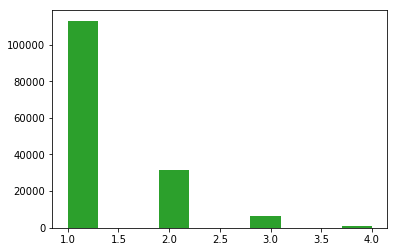

In [156]:
plt.hist(data.scenario_num)
plt.show()

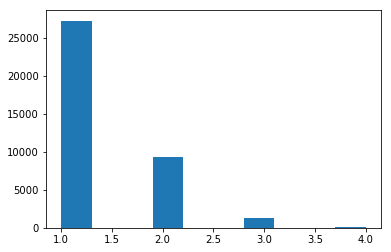

In [159]:
plt.hist(avg_data.scenario_num)
plt.show()

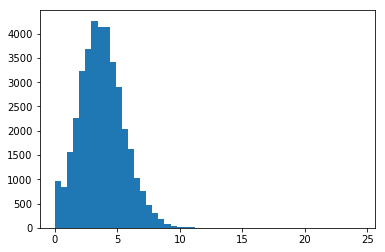

In [168]:
# windspeed repartition
plt.hist(avg_data.speed, bins = 50)
plt.show()

# Some visualizations, plots, analysis of the data

## Simple plot to show cyclicity of the features

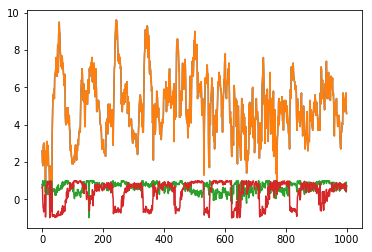

In [13]:
n = 1000
df = data
plt.plot(df["speed"].head(n))
plt.plot(df["cos_wind_dir"].head(n))
plt.plot(df["sin_wind_dir"].head(n))
#plt.figure(figsize=(40,40))
plt.rcParams["figure.figsize"] = (10,20)
plt.show()

## $y_{t+n}$ wrt $y_t$ 

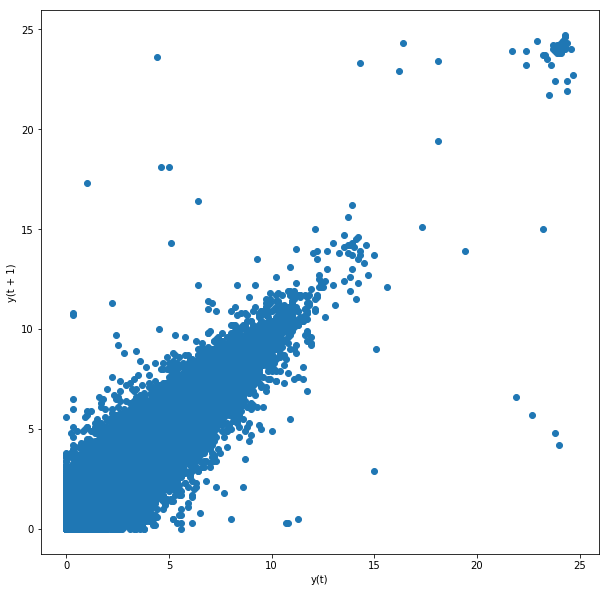

In [15]:
plt.rcParams["figure.figsize"] = (10,10)
y = df["speed"]
lag_plot(y)
pyplot.show()

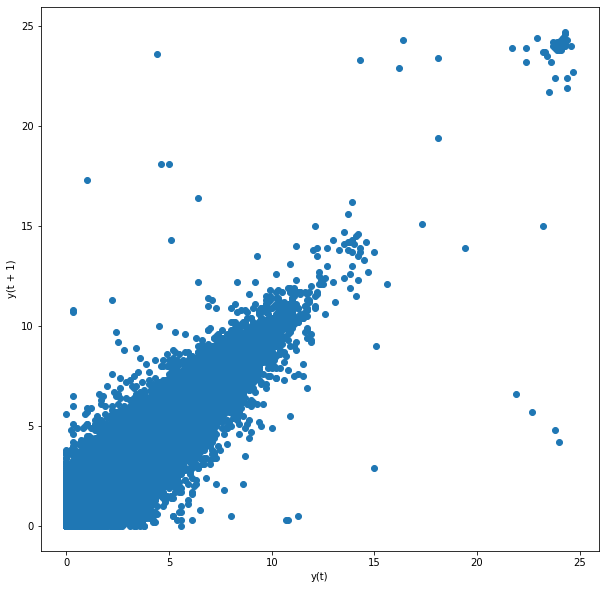

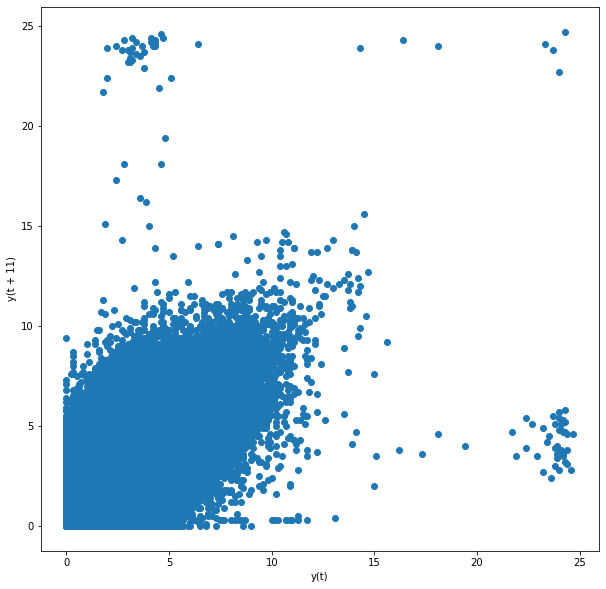

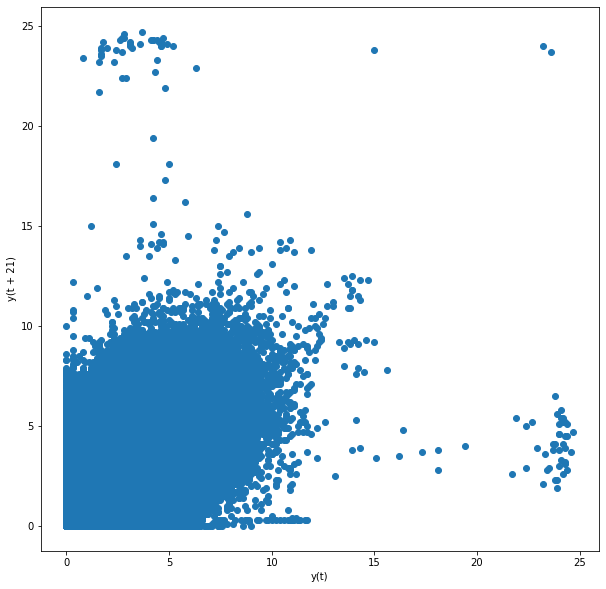

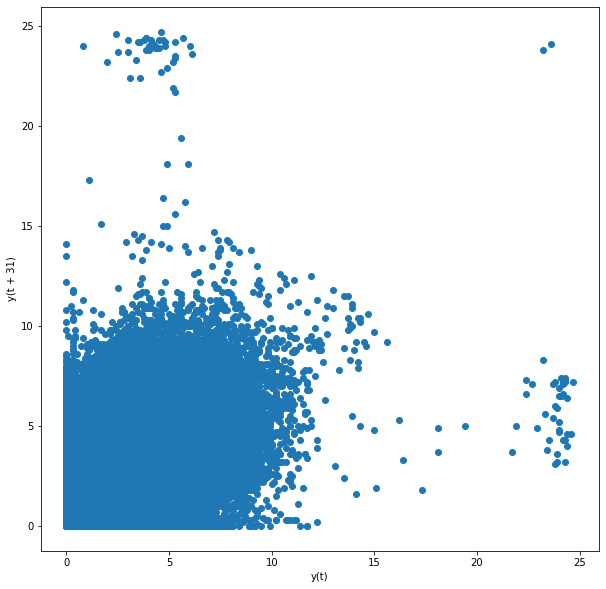

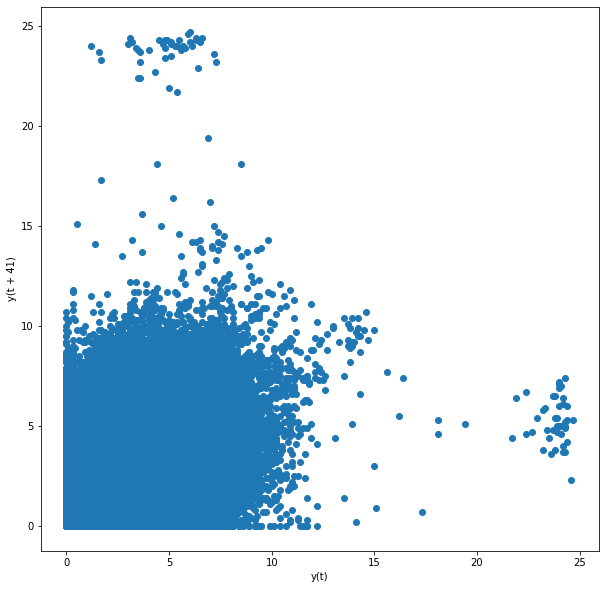

In [18]:
y = data[["speed"]]
for i in range(1, 50, 10):
    lag_plot(y, lag = i)
    plt.rcParams["figure.figsize"] = (10,10)
    pyplot.show()

# Seasonal analysis of the data

/Users/leobix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


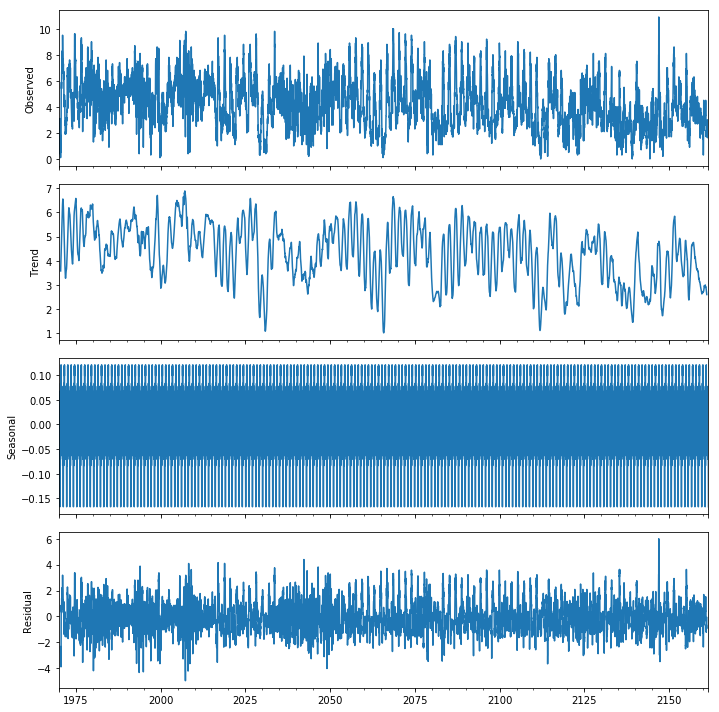

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose
df_speed = data["speed"][:10000]
df_speed.index = pd.DatetimeIndex(freq="w", start=0, periods=len(df_speed))
decomposed = seasonal_decompose(df_speed, model='additive')
x = decomposed.plot() #See note below about this
plt.show()

## Autocorrelation plot 

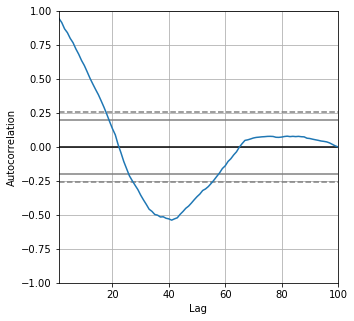

In [65]:
autocorrelation_plot(y.head(100))
plt.rcParams["figure.figsize"] = (5,5)
pyplot.show()

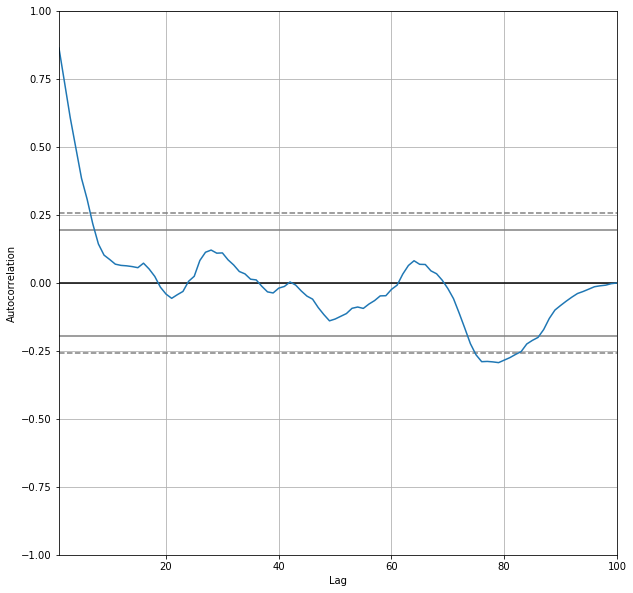

In [35]:
autocorrelation_plot(data["speed"].head(4000).tail(100))
plt.rcParams["figure.figsize"] = (10,10)
pyplot.show()

# Rolling mean

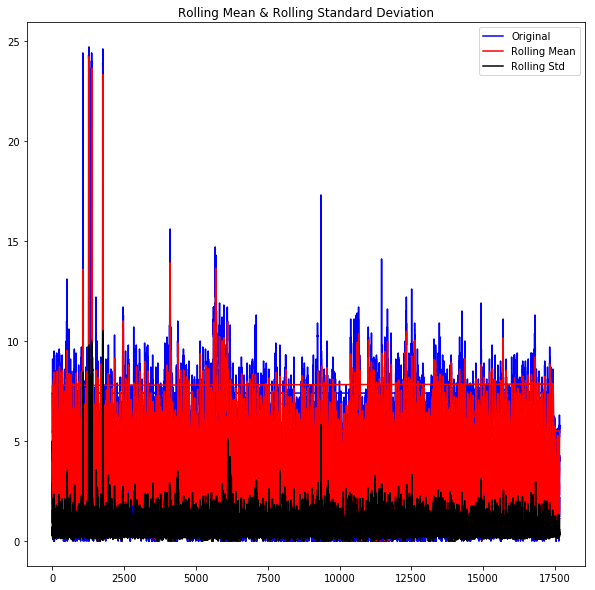

In [113]:
rolling_mean = y.rolling(window = 12).mean()
rolling_std = y.rolling(window = 12).std()
plt.plot(y, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

# Very simple prototyped prediction models

Test MSE: 0.120


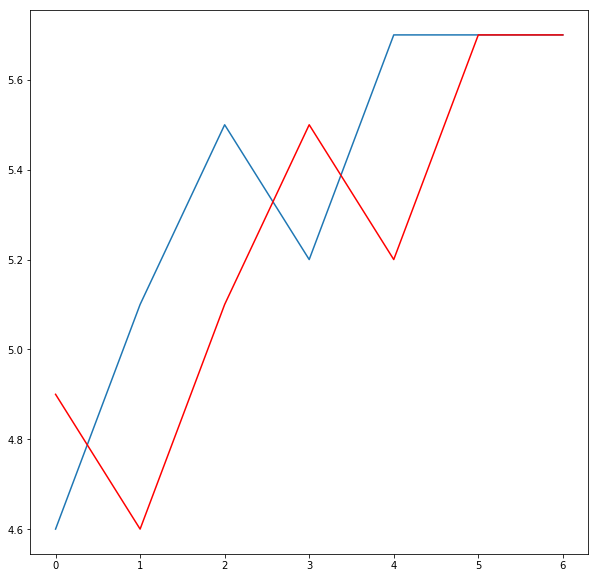

In [314]:
series = data.speed
# create lagged dataset
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
# split into train and test sets
X = dataframe.values
train, test = X[1:len(X)-7], X[len(X)-7:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

# persistence model
def model_persistence(x):
	return x

# walk-forward validation
predictions = list()
for x in test_X:
	yhat = model_persistence(x)
	predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)
# plot predictions vs expected
pyplot.plot(test_y)
pyplot.plot(predictions, color='red')
pyplot.show()

Lag: 75
Coefficients: [ 1.15845741e-01  8.54939077e-01  3.69066097e-02  3.19144434e-02
  1.57148965e-02  9.89786331e-03 -1.39713268e-04 -6.96727857e-03
 -7.38020355e-05  5.05316664e-03 -4.22690847e-03  1.00270264e-03
  3.38341768e-03 -8.17083661e-03 -3.30534677e-03  2.97181306e-03
  4.34260451e-03  2.86021860e-03  2.36364714e-03  4.46456649e-03
  1.56618941e-03 -9.09528208e-03  1.24522514e-03  4.91888314e-03
 -8.51147254e-03  2.25938127e-03  2.94842194e-03 -3.38077627e-03
  2.24185567e-03 -2.30787131e-03  2.81760294e-03  3.89001141e-03
  1.74730452e-04 -1.01089706e-02  5.26548459e-03  6.39499803e-03
 -6.53552997e-04 -5.80161823e-03 -3.94120887e-03 -4.42787165e-03
  4.66537561e-03  2.56353562e-03  1.23005530e-03 -4.20588949e-03
  5.24369413e-04 -5.23976868e-03  1.72378916e-03  2.80734016e-03
 -7.91001668e-03  2.48177047e-03  1.29945023e-03 -2.09869085e-03
 -1.35334491e-04  1.49735088e-03  2.69496569e-03  4.34537197e-04
 -2.81132949e-03 -1.88736112e-03  1.07638343e-03  3.29973423e-03
  1

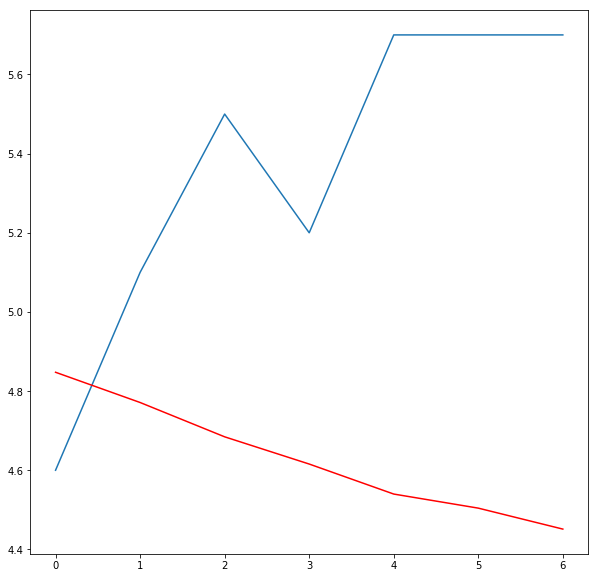

In [312]:
series = data.speed
# split dataset
X = series.values
train, test = X[1:len(X)-7], X[len(X)-7:]
# train autoregression
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test[i]))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot results
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

predicted=5.444221, expected=6.200000
predicted=5.969262, expected=5.200000
predicted=5.196177, expected=5.200000
predicted=5.219058, expected=4.700000
predicted=4.727747, expected=5.400000
predicted=5.281308, expected=6.100000
predicted=5.891172, expected=6.300000
predicted=6.114362, expected=5.400000
predicted=5.351573, expected=5.300000
predicted=5.233812, expected=5.500000
predicted=5.411869, expected=5.200000
predicted=5.121331, expected=5.400000
predicted=5.259510, expected=5.300000
predicted=5.183133, expected=5.100000
predicted=5.028278, expected=5.300000
predicted=5.207626, expected=4.800000
predicted=4.783596, expected=4.900000
predicted=4.847548, expected=4.600000
predicted=4.559363, expected=5.100000
predicted=4.956511, expected=5.500000
predicted=5.317199, expected=5.200000
predicted=5.076144, expected=5.700000
predicted=5.546454, expected=5.700000
predicted=5.551073, expected=5.700000
Test MSE: 0.199


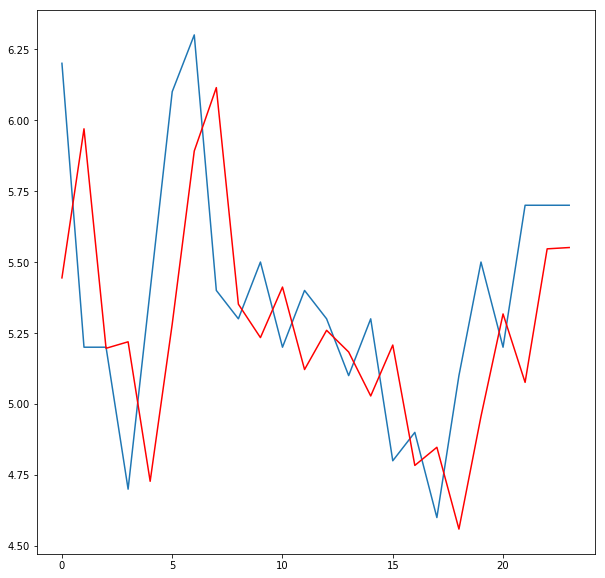

In [321]:
series = data["speed"]
# split dataset
X = series.values
train, test = X[1:len(X)-24], X[len(X)-24:]
# train autoregression
model = AR(train)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params
# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [38]:
model = ARIMA(data["speed"], order=(2,1,2))
results = model.fit(disp=-1)

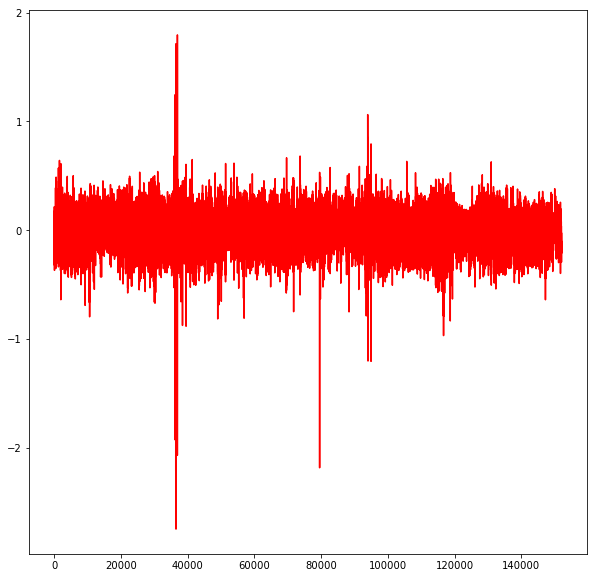

In [40]:
plt.plot(results.fittedvalues, color='red')
plt.show()

# LSTM

I started to write some code for an LSTM prediction, but it needs to be adapted to our format.

In [7]:
# multivariate multi-step encoder-decoder lstm example
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import numpy as np

/Users/leobix/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/leobix/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:455: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/leobix/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:456: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/leobix/anaconda3/lib/python3.6/site-p

In [8]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

n = 110000

# define input sequence
in_seq1 = np.array(data["speed"])[:n]
in_seq2 = np.array(data["cos_wind_dir"])[:n]
in_seq3 = np.array(data["sin_wind_dir"])[:n]

# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))

# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, in_seq3))
# choose a number of time steps
n_steps_in, n_steps_out = 480, 192
# convert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)

In [33]:
from keras.callbacks import ModelCheckpoint

In [34]:
# the dataset knows the number of features
n_features = X.shape[2]
# define model
model = Sequential()

model.add(LSTM(64, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))#, activation='softmax')))
model.compile(optimizer='adam', loss='mse')
# fit model
checkpoints = ModelCheckpoint('Users.safi', monitor='val_acc', verbose=1,
                                save_best_only=False, save_weights_only=True,
                                mode='auto', period=1)

model.fit(X, y, epochs=10, verbose=0, callbacks = [checkpoints])#, validation_data=(X_test, y_test),)

Epoch 00001: saving model to Users.safi
Epoch 00002: saving model to Users.safi
Epoch 00003: saving model to Users.safi
Epoch 00004: saving model to Users.safi
Epoch 00005: saving model to Users.safi
Epoch 00006: saving model to Users.safi
Epoch 00007: saving model to Users.safi
Epoch 00008: saving model to Users.safi
Epoch 00009: saving model to Users.safi
Epoch 00010: saving model to Users.safi


In [56]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 64)                17408     
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 192, 64)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 192, 64)           33024     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 192, 3)            195       
Total params: 50,627
Trainable params: 50,627
Non-trainable params: 0
_________________________________________________________________


In [95]:
pd.concat([DataFrame(data["speed"]), DataFrame(data["day"])])

/Users/leobix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            152054, 152055, 152056, 152057, 152058, 152059, 152060, 152061,
            152062, 152063],
           dtype='int64', name='_temporary_index_column', length=304128)

In [98]:
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh import extract_features

extracted_features = extract_features(pd.concat([DataFrame(data["speed"]), DataFrame(data["cos_wind_dir"])])[100:1000], column_id = "speed")
#impute(extracted_features)
#features_filtered = select_features(extracted_features, y)

/Users/leobix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


ValueError: You have NaN values in your value column.

### Now we test the model 

In [28]:
#m is the number of examples to test
m = 30000

# define input sequence
test_seq1 = np.array(data["speed"])[n:(n+m)]
test_seq2 = np.array(data["cos_wind_dir"])[n:(n+m)]
test_seq3 = np.array(data["sin_wind_dir"])[n:(n+m)]

# convert to [rows, columns] structure
test_seq1 = test_seq1.reshape((len(test_seq1), 1))
test_seq2 = test_seq2.reshape((len(test_seq2), 1))
test_seq3 = test_seq3.reshape((len(test_seq3), 1))

# horizontally stack columns
dataset_test = np.hstack((test_seq1, test_seq2, test_seq3))
# choose a number of time steps
# convert into input/output
X_test, y_test = split_sequences(dataset_test, n_steps_in, n_steps_out)

In [53]:
X_test.shape

(29329, 480, 3)

In [54]:
#our prediction
yhat_test = model.predict(X_test[0].reshape(1, 480, 3))
yhat_attempt = []
for i in range(len(X_test)):
    s = X_test[i,-1,0]
    c = X_test[i,-1,1]
    sin = X_test[i,-1,2]
    yhat_attempt.append([[s, c, sin] for i in range(n_steps_out)])
yhat_attempt = np.array(yhat_attempt)

In [55]:
yhat_test

array([[[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],


prediction [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
real data [3.7        3.8        3.8        3.2        4.         3.
 2.4        2.2        2.4        2.3        2.7        3.2
 3.3        3.4        3.2        4.         3.7        3.7
 3.3        2.7     

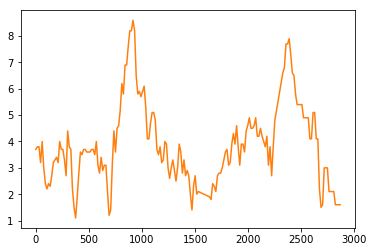

In [38]:
# one example of prediction
n = 10
pred = np.round(yhat_test[n,:,0], 1)
test = y_test[n,:,0]
print("prediction", pred)
print("real data", test)
plt.plot([15*i for i in range(n_steps_out)], pred)
plt.plot([15*i for i in range(n_steps_out)], test)
plt.show()

In [39]:
def loss(yhat, ytest, pred = 0):
    n = yhat.shape[0]
    err = []
    err_mean = []
    err_mean_abs = []
    for i in range(n):
        err.append(np.sum((np.round(yhat[i,:,pred], 1)-ytest[i,:,pred])**2))
        err_mean.append(list((np.round(yhat[i,:,pred], 1)-ytest[i,:,pred])**2))
        err_mean_abs.append(list(abs(np.round(yhat[i,:,pred], 1)-ytest[i,:,pred])))
    return np.mean(err), np.array(err_mean), np.array(err_mean_abs)

err, err_mean, err_mean_abs = loss(yhat_test, y_test)
print("The MSE is:", err)
for i in range(n_steps_out):
    print("The mean squared error for the timestep", i+1, "is: ", np.mean(err_mean[:,i]))
print()
for i in range(n_steps_out):
    print("The mean absolute error for the timestep", i+1, "is: ", np.mean(err_mean_abs[:,i]))

The MSE is: nan
The mean squared error for the timestep 1 is:  nan
The mean squared error for the timestep 2 is:  nan
The mean squared error for the timestep 3 is:  nan
The mean squared error for the timestep 4 is:  nan
The mean squared error for the timestep 5 is:  nan
The mean squared error for the timestep 6 is:  nan
The mean squared error for the timestep 7 is:  nan
The mean squared error for the timestep 8 is:  nan
The mean squared error for the timestep 9 is:  nan
The mean squared error for the timestep 10 is:  nan
The mean squared error for the timestep 11 is:  nan
The mean squared error for the timestep 12 is:  nan
The mean squared error for the timestep 13 is:  nan
The mean squared error for the timestep 14 is:  nan
The mean squared error for the timestep 15 is:  nan
The mean squared error for the timestep 16 is:  nan
The mean squared error for the timestep 17 is:  nan
The mean squared error for the timestep 18 is:  nan
The mean squared error for the timestep 19 is:  nan
The m

In [ ]:
#https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [275]:
clf = KNeighborsClassifier(24)
clf.fit(X_train, y_train_one_class)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test_one_class, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 69.17%


# XGBoost

In [180]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [316]:
model = XGBClassifier(max_depth = 3, n_estimators = 50)
model.fit(X_train, y_train_one_class)
#model.fit(X_train, y)
y_pred = model.predict(X_test)
#acc = accuracy_score(y_test_one_class, y_pred)
acc = accuracy_score(y_test_one_class, y_pred)
print("Accuracy: %.2f%%" % (acc * 100.0))

Accuracy: 75.05%


/Users/leobix/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


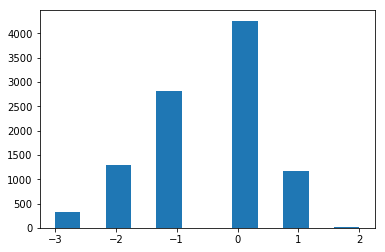

In [309]:
plt.hist(y_pred - y_test, bins = 12)
plt.show()

0.7519481833822488

In [52]:
y_pred = model.predict(X_test[:,24:,0])

/Users/leobix/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [54]:
mse = mean_squared_error(y_test[:,24,0], y_pred)
mae = mean_absolute_error(y_test[:,24,0], y_pred)
print("MSE: %.2f%%" % (mse))
print("MAE %.2f%%" % (mae))
#7 depth, 100 estimators, 4.299 on test set
#5 depth, 100, MSE 4.16, MAE = 1.56

MSE: 4.16%
MAE 1.56%


In [62]:
mse = mean_squared_error(y_test[:,24,0], X_test[:,47,0])
mae = mean_absolute_error(y_test[:,24,0], X_test[:,47,0])
print("Baseline MSE: %.2f%%" % (mse))
print("Baseline MAE %.2f%%" % (mae))

Baseline MSE: 4.56%
Baseline MAE 1.63%


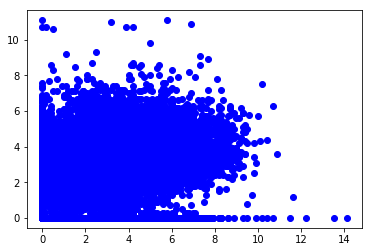

In [57]:
plt.plot(y_test[:,24,0], y_pred, 'bo')
plt.show()

In [58]:
print(model.feature_importances_)

[0.04198295 0.03818395 0.0404564  0.04003146 0.04139919 0.03841325
 0.03943534 0.0384791  0.03923595 0.03917813 0.03830309 0.03902938
 0.03928078 0.03948116 0.04018822 0.03994483 0.04006547 0.03910648
 0.03890779 0.04077559 0.03983012 0.03931347 0.04777089 0.08120697]


# TBATS

In [66]:
from tbats import TBATS

In [105]:
n = 1000
gap = 960 
y = data.speed[n:n+gap]

# Create estimator
estimator = TBATS(seasonal_periods=[96])

# Fit model
fitted_model = estimator.fit(y)

In [106]:
# Forecast 192 steps ahead
y_forecasted = fitted_model.forecast(steps=192)

# Summarize fitted model
print(fitted_model.summary())

Use Box-Cox: False
Use trend: True
Use damped trend: True
Seasonal periods: []
Seasonal harmonics []
ARMA errors (p, q): (0, 0)
Smoothing (Alpha): 0.877266
Trend (Beta): -0.107983
Damping Parameter (Phi): 0.882009
Seasonal Parameters (Gamma): []
AR coefficients []
MA coefficients []
Seed vector [4.54855843 0.05034197]

AIC 6129.662197


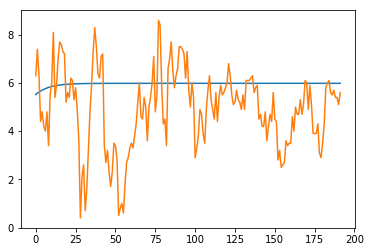

In [107]:
plt.plot([i for i in range(192)], y_forecasted)
plt.plot([i for i in range(192)], data.speed[n+gap:n+gap+192])
plt.show()

In [109]:
mae = mean_absolute_error(data.speed[n+gap:n+gap+192], y_forecasted)
mae

1.473546719371943

# VAR technique for multivariate forecasting

In [9]:
from statsmodels.tsa.vector_ar.var_model import VAR

In [42]:
p[data.speed[:1000], data.cos_wind_dir[:1000]]

[0      2.6
 1      2.0
 2      1.8
 3      2.5
 4      2.9
       ... 
 995    5.3
 996    5.1
 997    5.7
 998    4.8
 999    4.6
 Name: speed, Length: 1000, dtype: float64, 0      0.788011
 1      0.719340
 2      0.998630
 3      0.913545
 4      0.866025
          ...   
 995    0.669131
 996    0.743145
 997    0.857167
 998    0.920505
 999    0.694658
 Name: cos_wind_dir, Length: 1000, dtype: float64]

In [49]:
model = VAR(endog=dataset)
model_fit = model.fit()

In [59]:
dataset_test.shape

(30000, 3)

In [63]:
prediction = model_fit.forecast(dataset_test[:40], steps=192)

In [61]:
prediction.shape

(192, 3)

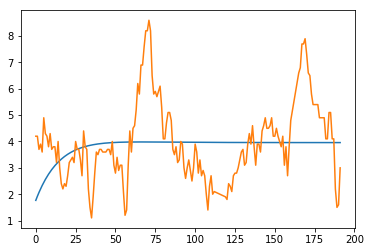

In [64]:
plt.plot([i for i in range(192)],prediction[:,0])
plt.plot([i for i in range(192)], y_test[0,:,0])
plt.show()